#Installing Dependancies

In [1]:
# Before proceeding run this cell (but if you have already install then ignore)
!pip install tensorflow==2.15.0
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

# Load Libraries

In [2]:
# dl packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud


# Load data

In [3]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [4]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [5]:
train_data.shape

(16000, 3)

In [6]:
train_data.isnull().sum()

,0
Comment,0
Emotion,0
length,0


In [7]:
train_data.duplicated().sum()

1

# EDA

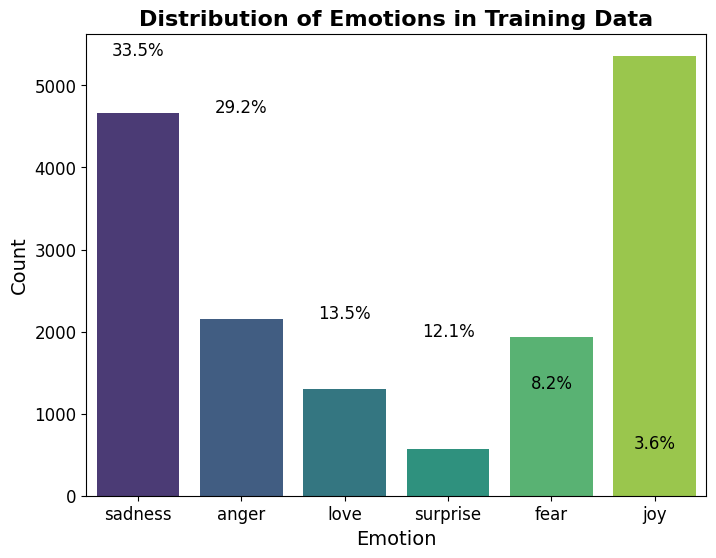

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Enhanced count plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=train_data, palette='viridis', hue='Emotion')  # Use hue to avoid warning

# Add title and labels
plt.title('Distribution of Emotions in Training Data', fontsize=16, fontweight='bold')
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display percentages above bars
emotion_counts = train_data['Emotion'].value_counts()
total = len(train_data['Emotion'])

for i, count in enumerate(emotion_counts):
    plt.text(i, count + 5, f'{(count / total) * 100:.1f}%', ha='center', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


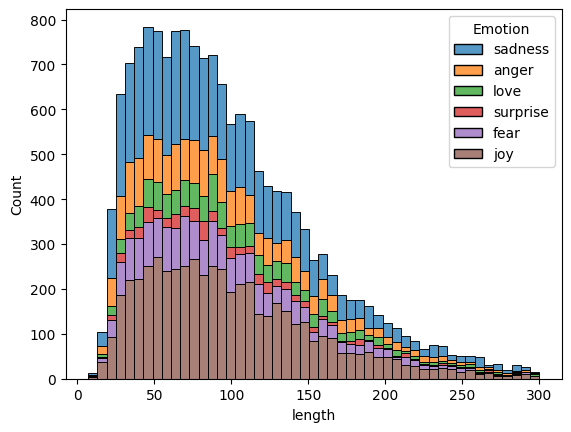

In [9]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

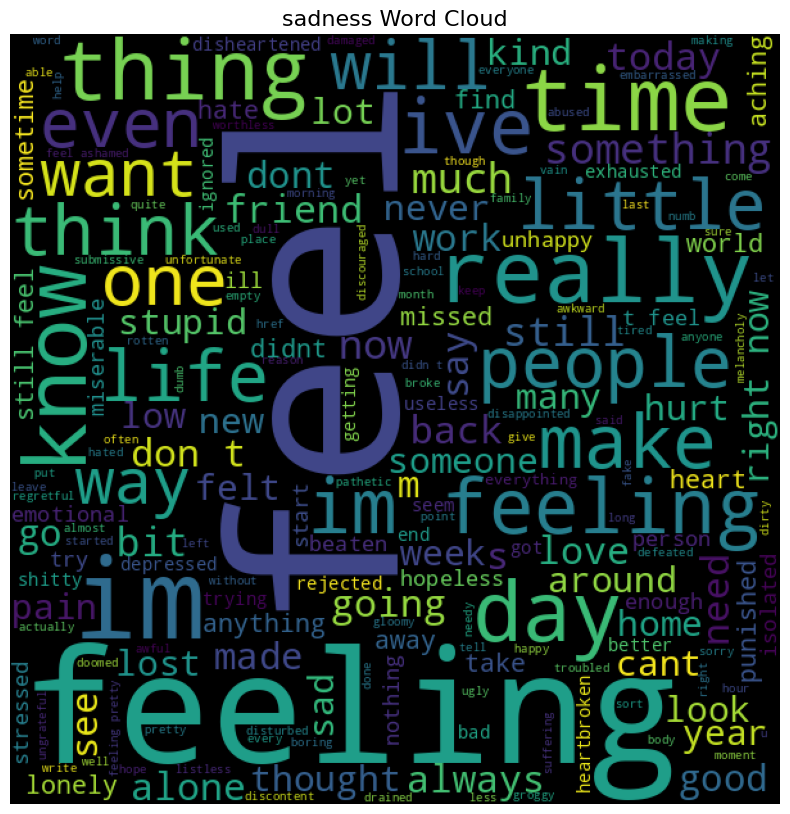

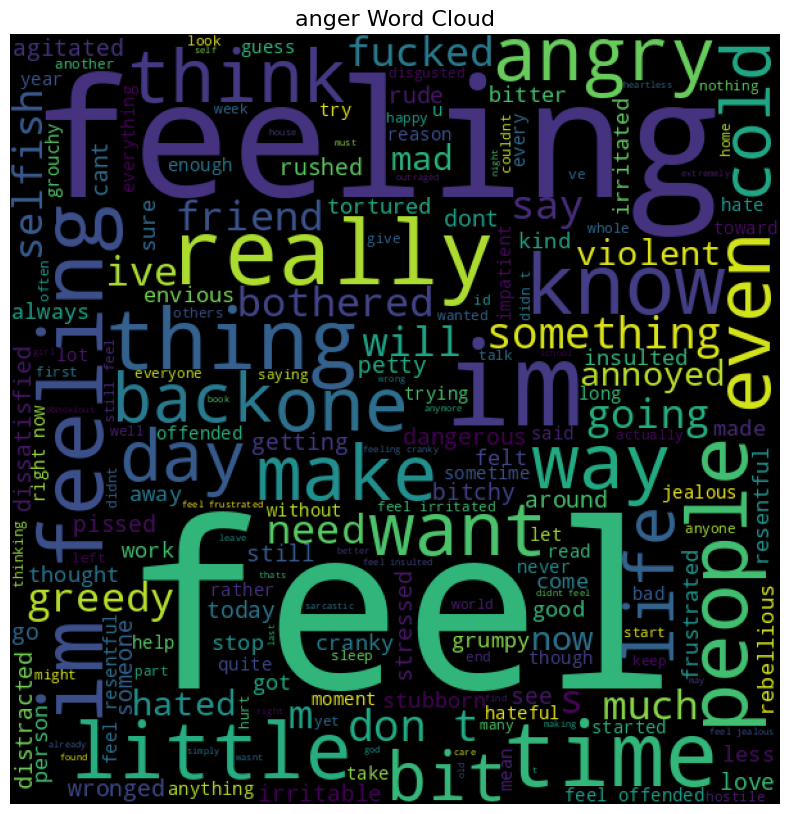

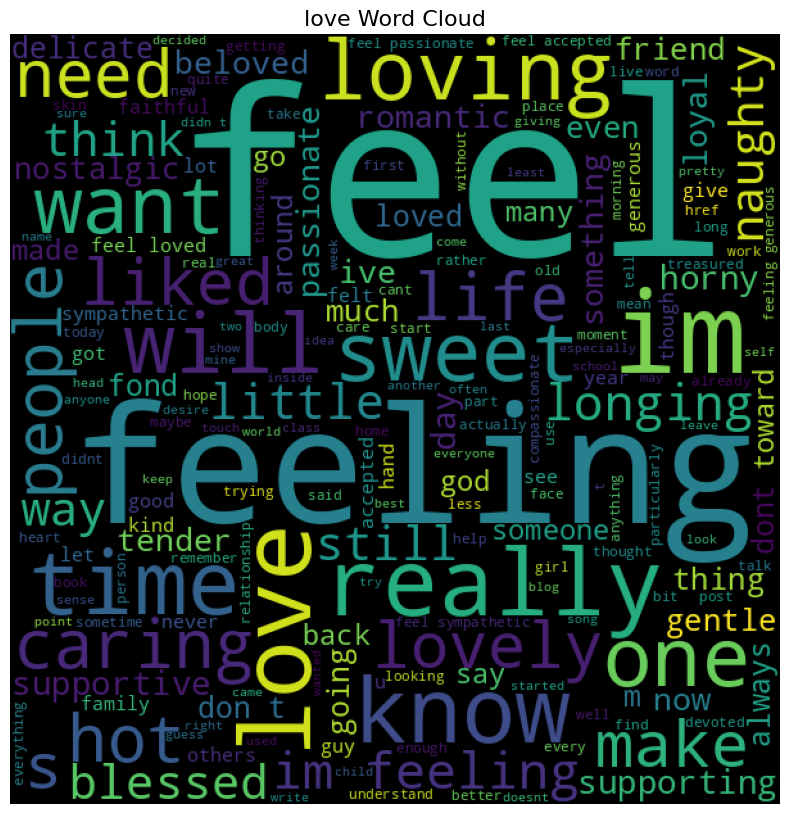

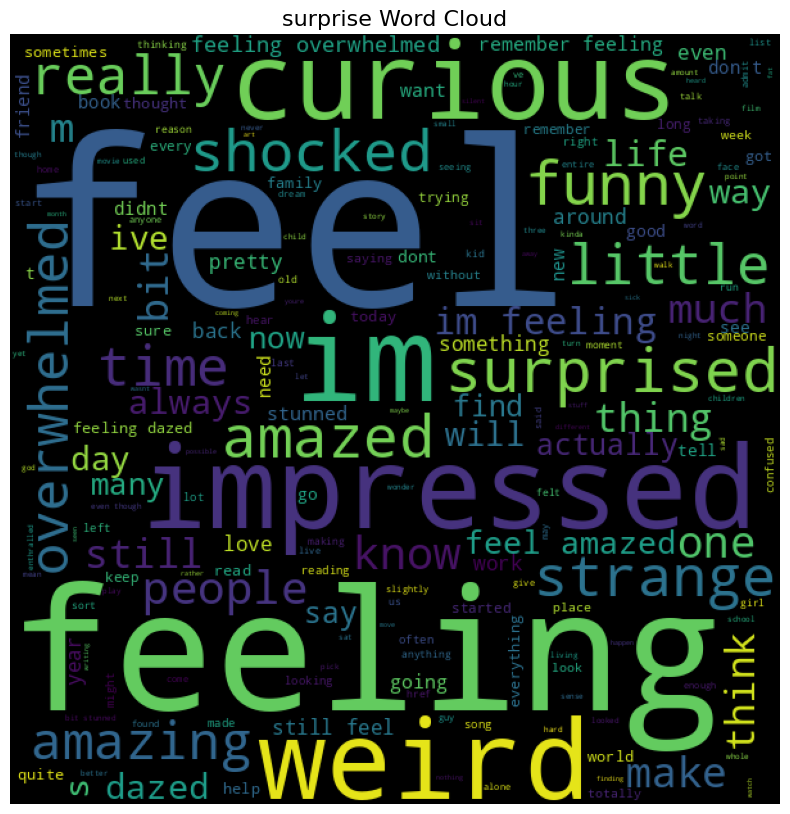

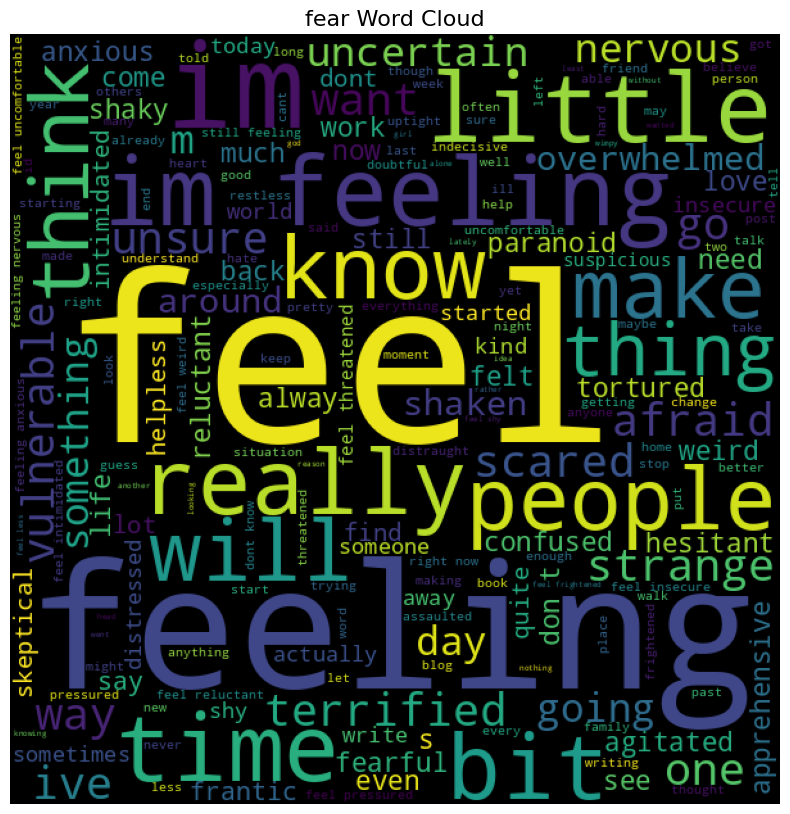

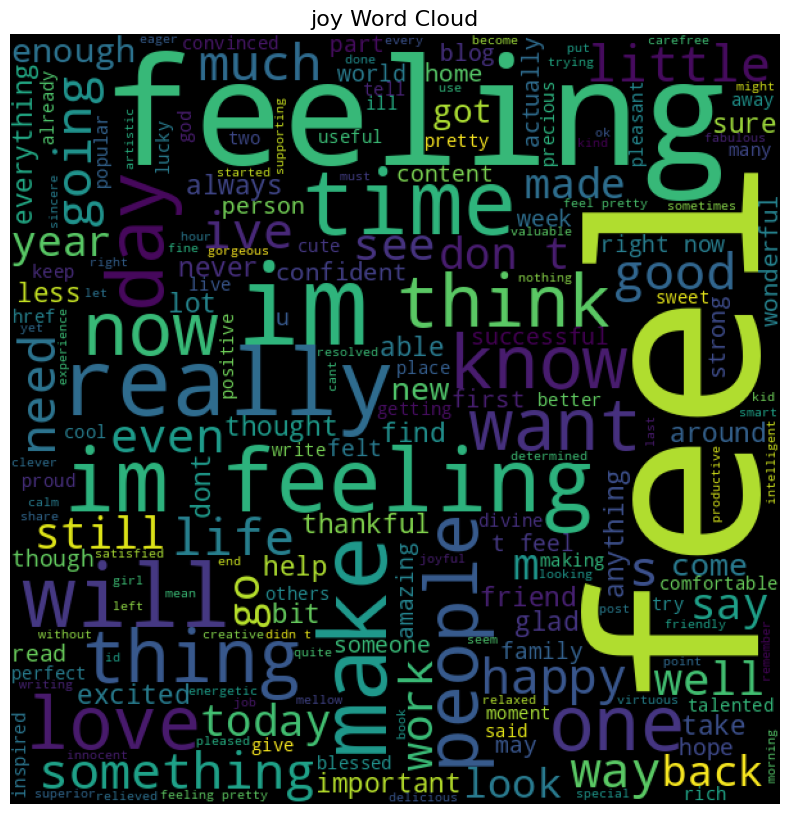

In [10]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# Data Preprocessing
# Encode emotions

In [11]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [12]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


# Applying Machine Learning

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [14]:
df = train_data.copy()

In [15]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [16]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [18]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [19]:
import numpy as np
import pandas as pd
import joblib
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define models and their hyperparameter grids
models_and_params = {
    "Multinomial Naive Bayes": {
        "model": MultinomialNB(),
        "params": {}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=10000),
        "params": {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    "Support Vector Machine": {
        "model": SVC(),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    }
}

# Dictionary to store the best models
best_models = {}
metrics = []

# Perform hyperparameter tuning and training
for name, model_info in models_and_params.items():
    print(f"Processing: {name}")
    model = model_info["model"]
    param_grid = model_info["params"]

    if param_grid:  # If there are hyperparameters to tune
        print(f"Performing Grid Search for {name}...")
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train_tfidf, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:  # If no hyperparameters to tune
        model.fit(X_train_tfidf, y_train)
        best_model = model

    # Evaluate the best model
    y_pred = best_model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-score": report['weighted avg']['f1-score']
    })

    # Store the best model
    best_models[name] = best_model

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Print all metrics
print("\nClassification Metrics for All Models:")
print(metrics_df)

# Find the best model based on accuracy
best_model_name = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']
best_model = best_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Metrics for Best Model:\n{metrics_df.loc[metrics_df['Model'] == best_model_name]}")

# Save the best model, label encoder, and tfidf vectorizer
joblib.dump(best_model, f'{best_model_name}_best_model.pkl')
pickle.dump(lb, open("label_encoder.pkl", 'wb'))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", 'wb'))

print(f"\nBest model ({best_model_name}) saved as {best_model_name}_best_model.pkl")


Processing: Multinomial Naive Bayes
Accuracy: 0.6550
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200

Processing: Logistic Regression
Performing Grid Search for Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.8534
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       427
           1    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [20]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Assuming best_models is defined from the previous cell (ipython-input-19)
classifiers = best_models  # Assign best_models to classifiers

# Store metrics
metrics = []

for name, clf in classifiers.items():
    #clf.fit(X_train_tfidf, y_train)  # Train the classifier with the original class labels
    y_pred_tfidf = clf.predict(X_test_tfidf)  # Make predictions
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)  # Compute accuracy
    report = classification_report(y_test, y_pred_tfidf, output_dict=True, zero_division=1)  # Classification report with zero_division=1
    metrics.append({
        "Model": name,
        "Accuracy": accuracy_tfidf,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-score": report['weighted avg']['f1-score']
    })

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Print all metrics
print("Classification Metrics for All Models:")
print(metrics_df)

# Get the best model based on accuracy
best_model_row = metrics_df.loc[metrics_df['Accuracy'].idxmax()]  # Change 'Accuracy' to other metric if needed

# Display the best model and its metrics
print("\nBest Model Based on Accuracy:")
print(best_model_row)


Classification Metrics for All Models:
                     Model  Accuracy  Precision    Recall  F1-score
0  Multinomial Naive Bayes  0.655000   0.757804  0.655000  0.581576
1      Logistic Regression  0.853437   0.851707  0.853437  0.850055
2            Random Forest  0.850625   0.850188  0.850625  0.848949
3   Support Vector Machine  0.858750   0.857442  0.858750  0.856062
4                 AdaBoost  0.328437   0.493747  0.328437  0.176962

Best Model Based on Accuracy:
Model        Support Vector Machine
Accuracy                    0.85875
Precision                  0.857442
Recall                      0.85875
F1-score                   0.856062
Name: 3, dtype: object


In [21]:
# Store metrics
metrics = []

for name, clf in classifiers.items():
    # No re-training; just use the existing model (assuming classifiers are pre-trained)
    y_pred_tfidf = clf.predict(X_test_tfidf)  # Predictions on the test data
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)  # Accuracy calculation
    report = classification_report(y_test, y_pred_tfidf, output_dict=True, zero_division=1)  # Avoid warning by setting zero_division
    metrics.append({
        "Model": name,
        "Accuracy": accuracy_tfidf,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-score": report['weighted avg']['f1-score']
    })

# Convert to DataFrame for easy display
metrics_df = pd.DataFrame(metrics)

best_model_row = metrics_df.loc[metrics_df['Accuracy'].idxmax()]
print(f"\nBest Model Based on Accuracy: {best_model_row['Model']}")



Best Model Based on Accuracy: Support Vector Machine


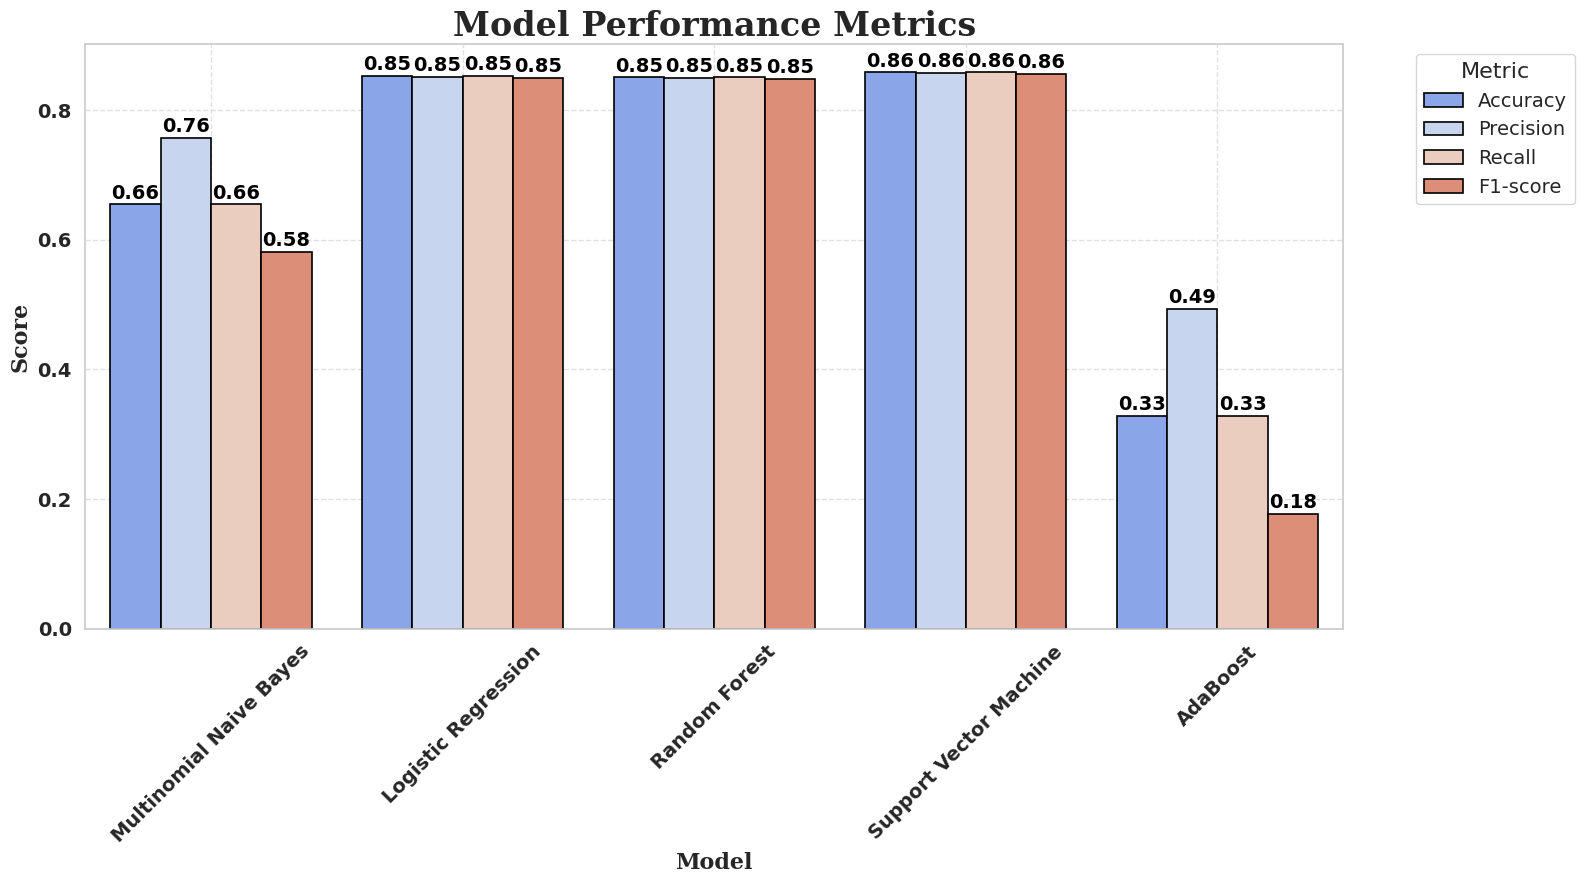

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style with advanced options
sns.set(style="whitegrid", palette="Blues")

# Plot metrics
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")
plt.figure(figsize=(16, 9))

# Create the bar plot with gradient color scale and custom palette
sns.barplot(data=metrics_melted, x="Model", y="Value", hue="Metric", dodge=True,
            palette="coolwarm", edgecolor="black", linewidth=1.2)

# Title and labels with custom fonts and advanced formatting
plt.title("Model Performance Metrics", fontsize=24, fontweight='bold', family='serif')
plt.xlabel("Model", fontsize=16, fontweight='bold', family='serif')
plt.ylabel("Score", fontsize=16, fontweight='bold', family='serif')

# Rotate x-ticks and increase font size for better readability
plt.xticks(rotation=45, fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

# Customize the gridlines for a cleaner look
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate bars with the values: added color and bold annotations for emphasis
for p in plt.gca().patches:
    height = p.get_height()

    # Only annotate if the height is greater than a small threshold (e.g., 0)
    if height > 0:
        plt.gca().annotate(f'{height:.2f}',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='center', fontsize=14,
                           color='black', fontweight='bold',
                           xytext=(0, 8), textcoords='offset points')

# Custom legend positioning and appearance
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)

# Refine layout to ensure no overlap and everything fits
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("y_train shape:", y_train.shape)

X_train_tfidf shape: (12800, 9257)
y_train shape: (12800,)


#Prediction On The Best ML Model

In [24]:
# Get the name of the best model
best_model_name = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']

# Get the actual best model from the best_models dictionary (storing pre-trained models)
best_model = best_models[best_model_name]

def predict_emotion(input_text, model=best_model, vectorizer=tfidf_vectorizer):
    # Clean and vectorize the input text
    cleaned_text = clean_text(input_text)  # Assuming a clean_text function exists
    input_vectorized = vectorizer.transform([cleaned_text])  # Vectorize the input text

    # Predict the emotion label
    predicted_label = model.predict(input_vectorized)[0]  # Get the predicted class label directly

    # Ensure the predicted label is 1D before using inverse_transform
    predicted_emotion = lb.inverse_transform([predicted_label])[0]  # Assuming 'lb' is your label encoder

    return predicted_emotion

# Example Sentences for Prediction
sentences = [
    "i didnt feel humiliated",
    "i feel strong and good overall",
    "im grabbing a minute to post i feel greedy wrong",
    "He was speechless when he found out he was accepted to this new job",
    "This is outrageous, how can you talk like that?",
    "I feel like im all alone in this world",
    "He is really sweet and caring",
    "You made me very crazy",
    "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
    "i am feeling grouchy",
    "He hates you"
]

# Print which model is being used
print(f"Using best model: {best_model_name}\n")

# Loop through sentences and predict emotions
for sentence in sentences:
    print("Input Text:", sentence)
    predicted_emotion = predict_emotion(sentence)
    print("Predicted Emotion:", predicted_emotion)
    print("================================================================")


Using best model: Support Vector Machine

Input Text: i didnt feel humiliated
Predicted Emotion: sadness
Input Text: i feel strong and good overall
Predicted Emotion: joy
Input Text: im grabbing a minute to post i feel greedy wrong
Predicted Emotion: anger
Input Text: He was speechless when he found out he was accepted to this new job
Predicted Emotion: joy
Input Text: This is outrageous, how can you talk like that?
Predicted Emotion: anger
Input Text: I feel like im all alone in this world
Predicted Emotion: sadness
Input Text: He is really sweet and caring
Predicted Emotion: love
Input Text: You made me very crazy
Predicted Emotion: sadness
Input Text: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Predicted Emotion: love
Input Text: i am feeling grouchy
Predicted Emotion: anger
Input Text: He hates you
Predicted Emotion: anger


In [25]:
import sklearn
print(sklearn.__version__)

1.6.0


# Applying Deep learning Using LSTM

# Text Cleaning, Ecoding, and Padding

In [26]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Text cleaning function
from keras.preprocessing.text import text_to_word_sequence, one_hot  # Import one_hot from keras.preprocessing.text

def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in nltk.corpus.stopwords.words('english')]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus] # Now you can use one_hot here
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

# Split data into train and test sets for evaluation
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train_data, test_size=0.2, random_state=42)

# Apply text cleaning to the test set
x_test = text_cleaning(test_df, "Comment", vocab_size=11000, max_len=300)
y_test = to_categorical(test_df["Emotion"])

# Model Building and Training

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Build and compile the model
model = Sequential([
    Embedding(input_dim=11000, output_dim=150, input_length=300),  # Embedding layer
    Dropout(0.2),                                                 # Regularization
    LSTM(128),                                                    # LSTM layer
    Dropout(0.2),                                                 # Regularization
    Dense(64, activation='relu'),                                 # Hidden dense layer
    Dropout(0.2),                                                 # Regularization
    Dense(6, activation='softmax')                                # Output layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=10,
                    batch_size=64,
                    verbose=1,
                    callbacks=[callback])

# Check available metrics in the history
print("Available metrics:", history.history.keys())


Epoch 1/10
200/200 [==============================] - 181s 886ms/step - loss: 1.3582 - accuracy: 0.4679 - val_loss: 0.8656 - val_accuracy: 0.7028
Epoch 2/10
200/200 [==============================] - 181s 902ms/step - loss: 0.5043 - accuracy: 0.8338 - val_loss: 0.5080 - val_accuracy: 0.8331
Epoch 3/10
200/200 [==============================] - 181s 901ms/step - loss: 0.2490 - accuracy: 0.9145 - val_loss: 0.3934 - val_accuracy: 0.8556
Epoch 4/10
200/200 [==============================] - 173s 867ms/step - loss: 0.1642 - accuracy: 0.9440 - val_loss: 0.4262 - val_accuracy: 0.8637
Epoch 5/10
200/200 [==============================] - 172s 862ms/step - loss: 0.1282 - accuracy: 0.9568 - val_loss: 0.4766 - val_accuracy: 0.8559
Available metrics: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


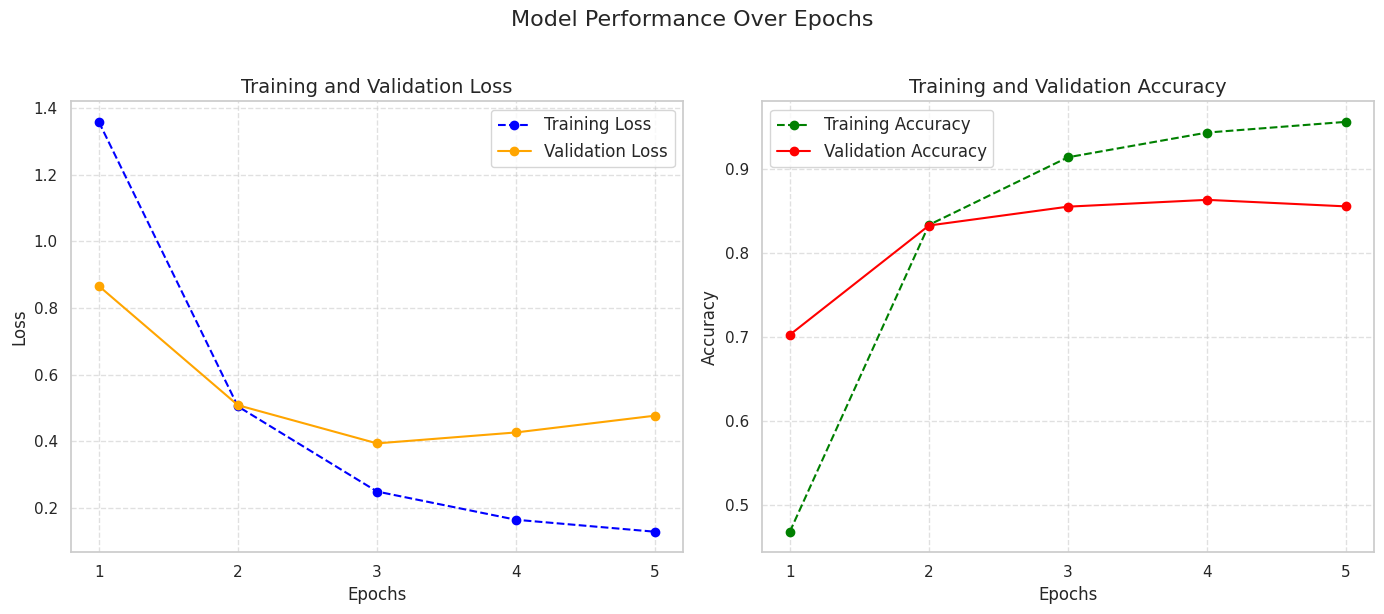

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_theme(style="whitegrid")

# Assuming `history` is the result of model.fit()
history_dict = history.history

# Extract metrics
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']
val_loss = history_dict.get('val_loss', [])
val_accuracy = history_dict.get('val_accuracy', [])
epochs = range(1, len(train_loss) + 1)

# Create a figure for Loss and Accuracy plots
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='--', color='blue')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='--', color='green')
if val_accuracy:
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-', color='red')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)

# Add overall title and layout adjustment
plt.suptitle('Model Performance Over Epochs', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [31]:
from sklearn.metrics import classification_report
import numpy as np

# Classification Report
def plot_classification_report(model, x_test, y_test, class_names):
    y_pred_probs = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("Classification Report:\n")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Example usage
# Define class_names before calling the function
class_names = ["Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise"]
plot_classification_report(model, x_test, y_test, class_names)

100/100 [==============================] - 18s 173ms/step
Classification Report:

              precision    recall  f1-score   support

       Anger       0.82      0.88      0.85       427
     Disgust       0.80      0.86      0.83       397
        Fear       0.90      0.86      0.88      1021
   Happiness       0.73      0.72      0.72       296
     Sadness       0.91      0.90      0.90       946
    Surprise       0.77      0.74      0.76       113

    accuracy                           0.86      3200
   macro avg       0.82      0.83      0.82      3200
weighted avg       0.86      0.86      0.86      3200



100/100 [==============================] - 17s 175ms/step


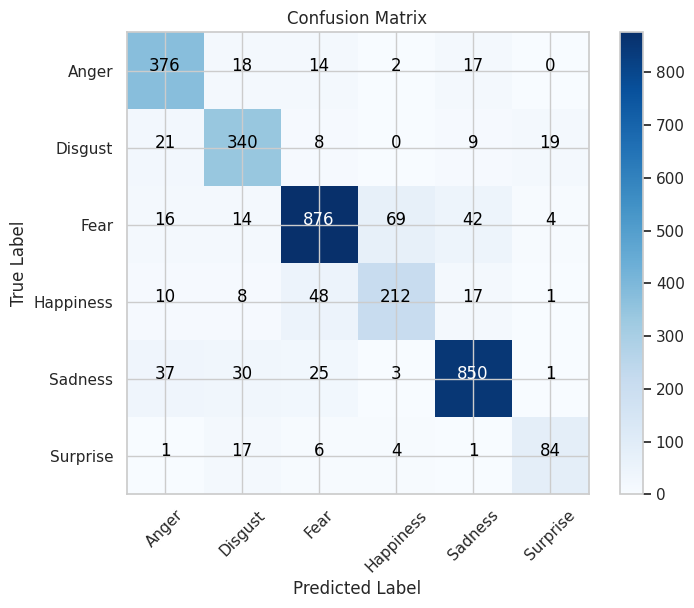

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix
def plot_confusion_matrix(model, x_test, y_test, class_names):
    y_pred_probs = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], horizontalalignment='center',
                     color='white' if cm[i, j] > cm.max() / 2. else 'black')

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Example usage
plot_confusion_matrix(model, x_test, y_test, class_names)


100/100 [==============================] - 18s 176ms/step


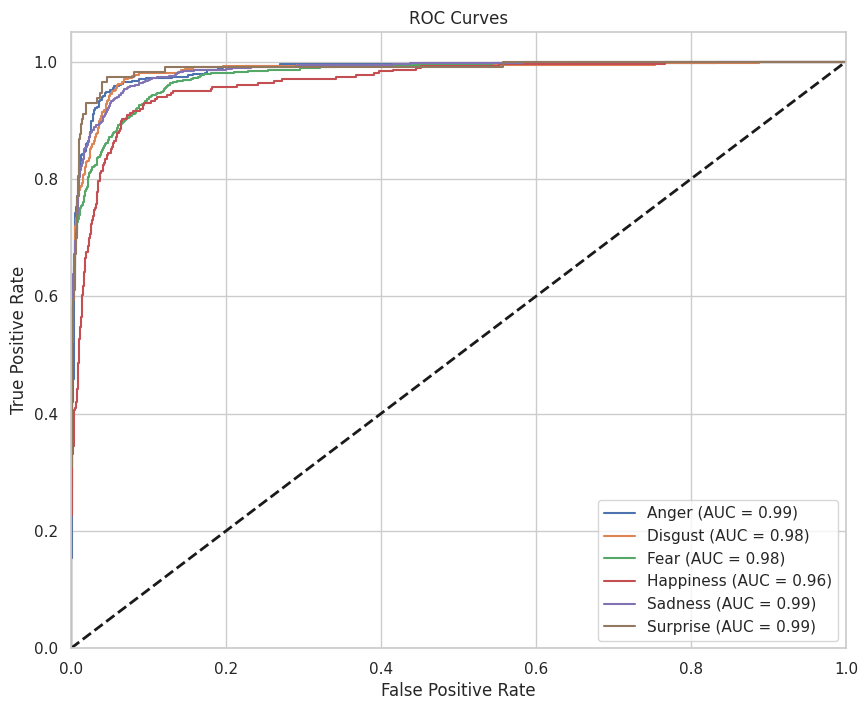

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves(model, x_test, y_test, class_names):
    # Predict probabilities
    y_pred_probs = model.predict(x_test)

    # Plot ROC Curves
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

class_names = ["Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise"]
plot_roc_curves(model, x_test, y_test, class_names)

# Predictive System

In [34]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    # Fix: Call words() directly from nltk.corpus.stopwords instead of using the 'stopwords' variable
    text = [stemmer.stem(word) for word in text if word not in nltk.corpus.stopwords.words('english')]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict
sentences = [
            "i feel strong and good overall",
            "i spent a lot of time feeling a bit stunned that they thought i was that awesome",
            "i feel like i am doing fantastic",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "She is really sweet and caring",
            "i want to hold this feeling of shocked awe and wonder forever",
            "The other person is scared of dogs",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 [==============================] - 0s 115ms/step
joy : 0.9954659938812256


i spent a lot of time feeling a bit stunned that they thought i was that awesome
1/1 [==============================] - 0s 115ms/step
surprise : 0.8919599056243896


i feel like i am doing fantastic
1/1 [==============================] - 0s 100ms/step
joy : 0.9937034249305725


This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 113ms/step
anger : 0.7521122694015503


I feel like im all alone in this world
1/1 [==============================] - 0s 99ms/step
sadness : 0.6022384762763977


She is really sweet and caring
1/1 [==============================] - 0s 93ms/step
love : 0.7665534019470215


i want to hold this feeling of shocked awe and wonder forever
1/1 [==============================] - 0s 72ms/step
surprise : 0.6556688547134399


The other person is scared of dogs
1/1 [==============================] - 0s 69ms/step
fear : 0.75078

# Save the model and files

In [35]:
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
import tensorflow as tf
import keras
from keras.models import load_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.stem import PorterStemmer
import pickle

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))


# Load the saved model, label encoder, and vocabulary info
model = load_model('model1.h5')
with open('lb1.pkl', 'rb') as f:
    lb = pickle.load(f)
with open('vocab_info.pkl', 'rb') as f:
    vocab_info = pickle.load(f)

vocab_size = vocab_info['vocab_size']
max_len = vocab_info['max_len']


# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad


def predict_emotion(input_text):
    cleaned_text = sentence_cleaning(input_text)
    result = lb.inverse_transform(np.argmax(model.predict(cleaned_text), axis=-1))[0]
    proba = np.max(model.predict(cleaned_text))
    print(f"Predicted Emotion: {result}, Probability: {proba}")
    return result

# Get user input
user_input = input("Enter a statement: ")

# Predict the emotion
predicted_emotion = predict_emotion(user_input)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Enter a statement: i am feeling excited now after hearing it
1/1 [==============================] - 0s 65ms/step
Predicted Emotion: joy, Probability: 0.9829652905464172


In [37]:
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

2.15.0
2.15.0
